In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
TillerData = pd.read_excel('..\data\Lincoln2024.xlsx', sheet_name='Tiller# data')

In [3]:
SimNames = ['Lincoln2024SD20MarNNil',
 'Lincoln2024SD20MarNLow',
 'Lincoln2024SD20MarNMid',
 'Lincoln2024SD20MarNHigh',
 'Lincoln2024SD16AprNNil',
 'Lincoln2024SD16AprNLow',
 'Lincoln2024SD16AprNMid',
 'Lincoln2024SD16AprNHigh']

sowDates = ['20Mar'] * 4 + ['16Apr'] * 4
SowDates = dict(zip(SimNames,sowDates))
nRates = ['Nil','Low','Mid','High'] *2
NRates =  dict(zip(SimNames,nRates))

TillerData.loc[:,'SowDate'] = [SowDates[x] for x in TillerData.SimulationName]
TillerData.loc[:,'NRate'] = [NRates[x] for x in TillerData.SimulationName]

TillerData.columns = ['SimulationName', 'Clock.Today',
       'Random Tiller No.','Marked Tiller No.', 'SowDate', 'NRate']

TillerData.set_index(['SowDate','NRate'],inplace=True)
TillerData.sort_index(inplace=True)

In [4]:
earlyFilter = TillerData.loc[:,'Clock.Today'] < dt.datetime(2024,6,5)
EarlyData = TillerData.loc[earlyFilter,['SimulationName','Clock.Today','Marked Tiller No.']].dropna()
EarlyData.set_index(['SimulationName','Clock.Today'],append=True,inplace=True)
EarlyData.columns = ['Wheat.Leaf.StemNumberPerPlant']

LateData = TillerData.loc[:,['SimulationName','Clock.Today','Random Tiller No.']].dropna()
LateData.set_index(['SimulationName','Clock.Today'],append=True,inplace=True)
LateData.columns = ['Wheat.Leaf.StemNumberPerPlant']

mergedData = pd.concat([EarlyData,LateData])
mergedData.loc[:,'Clock.Today'] = mergedData.index.get_level_values(3)


C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_2288\268023201.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(mergedData.loc[(s,n),'Clock.Today'],
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_2288\268023201.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  mergedData.loc[(s,n),'Wheat.Leaf.StemNumberPerPlant'],'-',ms=5,color = 'k')


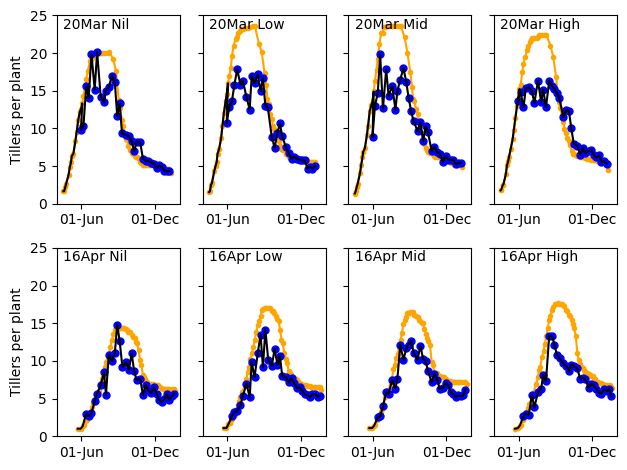

In [5]:
Graph =  plt.figure()
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        plt.plot(TillerData.loc[(s,n),'Clock.Today'],
                 TillerData.loc[(s,n),'Marked Tiller No.'],'o-',ms=3,color = 'orange')
        plt.plot(TillerData.loc[(s,n),'Clock.Today'],
                 TillerData.loc[(s,n),'Random Tiller No.'],'o',ms=5,color = 'b')
        plt.plot(mergedData.loc[(s,n),'Clock.Today'],
                 mergedData.loc[(s,n),'Wheat.Leaf.StemNumberPerPlant'],'-',ms=5,color = 'k')
        plt.ylim(0,25)
        plt.xlim(dt.date(2024,4,1),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Tillers per plant')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

In [6]:
#execute lines below to strip index and copy merged data 

#mergedData.index = mergedData.index.droplevel([0,1,3])
#mergedData.to_clipboard()

In [7]:
QuadratData = pd.read_excel('../Data/Lincoln2024.xlsx', sheet_name='Observed')
QuadratData.loc[:,'SowDate'] = [SowDates[x] for x in QuadratData.SimulationName]
QuadratData.loc[:,'NRate'] = [NRates[x] for x in QuadratData.SimulationName]

QuadratData.set_index(['SowDate','NRate'],inplace=True)
QuadratData.sort_index(inplace=True)

In [8]:
biomassVars = ['Wheat.Leaf.Live.Wt', 'Wheat.Stem.Wt', 'Wheat.Leaf.Dead.Wt', 'Wheat.Ear.Wt']

In [9]:
for v in biomassVars:
    for i in QuadratData.index:
        QuadratData.loc[i,'Propn_'+v] = QuadratData.loc[i,v]/QuadratData.loc[i,'Wheat.AboveGround.Wt']

In [10]:
RandomStems = pd.read_excel('..\data\Lincoln2024.xlsx', sheet_name='Random stem biomass partit')
RandomStems.loc[:,'SowDate'] = [SowDates[x] for x in RandomStems.SimulationName]
RandomStems.loc[:,'NRate'] = [NRates[x] for x in RandomStems.SimulationName]

RandomStems.set_index(['SowDate','NRate'],inplace=True)
RandomStems.sort_index(inplace=True) 

In [11]:
RandomStems.loc[:,'Wheat.AboveGround.Wt'] = RandomStems.loc[:,['Wheat.Leaf.Live.Wt/stem (g)','Wheat.Stem.Wt/stem (g)', 'Wheat.Leaf.Dead.Wt/stem (g)','Wheat.Ear.Wt/stem (g)']].sum(axis=1)
for v in biomassVars:
    for i in RandomStems.index:
        RandomStems.loc[i,'Propn_'+v] = RandomStems.loc[i,v+'/stem (g)']/RandomStems.loc[i,'Wheat.AboveGround.Wt']

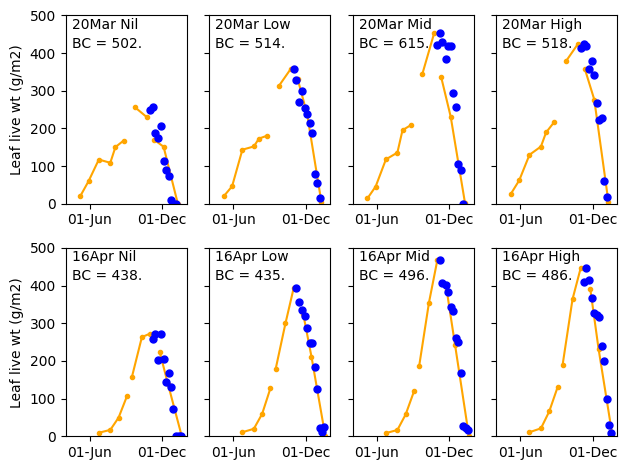

In [12]:
Graph =  plt.figure()
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        cf = QuadratData.loc[(s,n),'Wheat.Leaf.Live.Wt'].max()/RandomStems.loc[(s,n),'Wheat.Leaf.Live.Wt/stem (g)'].max()
        RandomStems.loc[(s,n),'Corrected_Wheat.Leaf.Live.Wt'] = RandomStems.loc[(s,n),'Wheat.Leaf.Live.Wt/stem (g)']*cf
        plt.plot(QuadratData.loc[(s,n),'Clock.Today'],
                 QuadratData.loc[(s,n),'Wheat.Leaf.Live.Wt'],'o-',ms=3,color = 'orange')
        
        plt.plot(RandomStems.loc[(s,n),'Clock.Today'],
                 RandomStems.loc[(s,n),'Corrected_Wheat.Leaf.Live.Wt'],'o',ms=5,color = 'b')
        plt.ylim(0,500)
        plt.xlim(dt.date(2024,4,1),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Leaf live wt (g/m2)')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

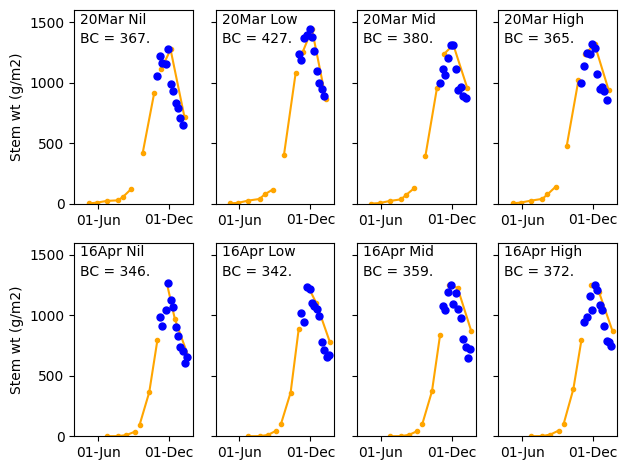

In [13]:
Graph =  plt.figure()
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        cf = QuadratData.loc[(s,n),'Wheat.Stem.Wt'].max()/RandomStems.loc[(s,n),'Wheat.Stem.Wt/stem (g)'].max()
        RandomStems.loc[(s,n),'Corrected_Wheat.Stem.Wt'] = RandomStems.loc[(s,n),'Wheat.Stem.Wt/stem (g)']*cf
        plt.plot(QuadratData.loc[(s,n),'Clock.Today'],
                 QuadratData.loc[(s,n),'Wheat.Stem.Wt'],'o-',ms=3,color = 'orange')
        plt.plot(RandomStems.loc[(s,n),'Clock.Today'],
                 RandomStems.loc[(s,n),'Corrected_Wheat.Stem.Wt'],'o',ms=5,color = 'b')
        plt.ylim(0,1600)
        plt.xlim(dt.date(2024,4,1),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Stem wt (g/m2)')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

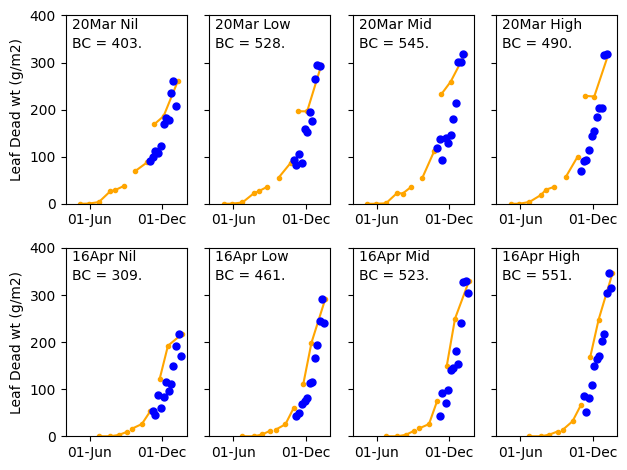

In [14]:
Graph =  plt.figure()
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        cf = QuadratData.loc[(s,n),'Wheat.Leaf.Dead.Wt'].max()/RandomStems.loc[(s,n),'Wheat.Leaf.Dead.Wt/stem (g)'].max()
        RandomStems.loc[(s,n),'Corrected_Wheat.Leaf.Dead.Wt'] = RandomStems.loc[(s,n),'Wheat.Leaf.Dead.Wt/stem (g)']*cf
        plt.plot(QuadratData.loc[(s,n),'Clock.Today'],
                 QuadratData.loc[(s,n),'Wheat.Leaf.Dead.Wt'],'o-',ms=3,color = 'orange')
        plt.plot(RandomStems.loc[(s,n),'Clock.Today'],
                 RandomStems.loc[(s,n),'Corrected_Wheat.Leaf.Dead.Wt'],'o',ms=5,color = 'b')
        plt.ylim(0,400)
        plt.xlim(dt.date(2024,4,1),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Leaf Dead wt (g/m2)')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

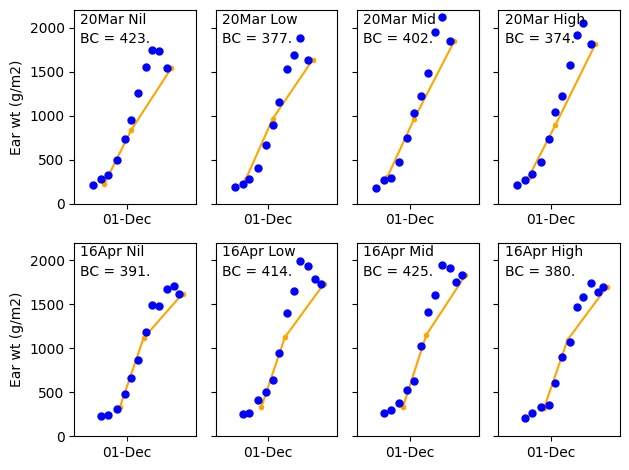

In [15]:
Graph =  plt.figure()
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        cf = QuadratData.loc[(s,n),'Wheat.Ear.Wt'].dropna().iloc[-1]/RandomStems.loc[(s,n),'Wheat.Ear.Wt/stem (g)'].dropna().iloc[-1]
        RandomStems.loc[(s,n),'Corrected_Wheat.Ear.Wt'] = RandomStems.loc[(s,n),'Wheat.Ear.Wt/stem (g)']*cf
        plt.plot(QuadratData.loc[(s,n),'Clock.Today'],
                 QuadratData.loc[(s,n),'Wheat.Ear.Wt'],'o-',ms=3,color = 'orange')
        plt.plot(RandomStems.loc[(s,n),'Clock.Today'],
                 RandomStems.loc[(s,n),'Corrected_Wheat.Ear.Wt'],'o',ms=5,color = 'b')
        plt.ylim(0,2200)
        plt.xlim(dt.date(2024,10,15),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Ear wt (g/m2)')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

In [16]:
SimNames23 = ['Lincoln2023SD27MarCVGraham',
 'Lincoln2023SD19AprCVGraham',
 'Lincoln2023SD18MayCVGraham',
 'Lincoln2023SD27MarCVKerrin',
 'Lincoln2023SD19AprCVKerrin',
 'Lincoln2023SD18MayCVKerrin',
 'Lincoln2023SD27MarCVSorrial',
 'Lincoln2023SD19AprCVSorrial',
 'Lincoln2023SD18MayCVSorrial',
 'Lincoln2023SD27MarCVVoltron',
 'Lincoln2023SD19AprCVVoltron',
 'Lincoln2023SD18MayCVVoltron',
 'Lincoln2023SD18MayCVCesario',
 'Lincoln2023SD18MayCVStockade']

sowDates23 = ['27Mar','19Apr','18May'] * 4 + ['18May'] * 2
SowDates23 = dict(zip(SimNames23,sowDates23))
cvs23 = ['Graham'] * 3 + ['Kerrin'] * 3 + ['Sorrial'] * 3 + ['Voltron'] * 3 + ['Cesario','Stockade']
Cvs23 = dict(zip(SimNames23,cvs23))

QuadratData23 = pd.read_excel('../Data/Lincoln2023.xlsx', sheet_name='Observed')
QuadratData23.loc[:,'SowDate'] = [SowDates23[x] for x in QuadratData23.SimulationName]
QuadratData23.loc[:,'CV'] = [Cvs23[x] for x in QuadratData23.SimulationName]

QuadratData23.set_index(['SowDate','CV'],inplace=True)
QuadratData23.sort_index(inplace=True)

In [17]:
for v in biomassVars:
    for i in QuadratData23.index:
        QuadratData23.loc[i,'Propn_'+v] = QuadratData23.loc[i,v]/QuadratData23.loc[i,'Wheat.AboveGround.Wt']

In [18]:
RandomStems23 = pd.read_excel('..\data\Lincoln2023.xlsx', sheet_name='Random stem biomass partit')
RandomStems23.loc[:,'SowDate'] = [SowDates23[x] for x in RandomStems23.SimulationName]
RandomStems23.loc[:,'CV'] = [Cvs23[x] for x in RandomStems23.SimulationName]

RandomStems23.set_index(['SowDate','CV'],inplace=True)
RandomStems23.sort_index(inplace=True) 

In [19]:
RandomStems23.loc[:,'Wheat.AboveGround.Wt'] = RandomStems23.loc[:,['Wheat.Leaf.Live.Wt/stem (g)','Wheat.Stem.Wt/stem (g)', 'Wheat.Leaf.Dead.Wt/stem (g)','Wheat.Ear.Wt/stem (g)']].sum(axis=1)
for v in biomassVars:
    for i in RandomStems23.index:
        RandomStems23.loc[i,'Propn_'+v] = RandomStems23.loc[i,v+'/stem (g)']/RandomStems23.loc[i,'Wheat.AboveGround.Wt']

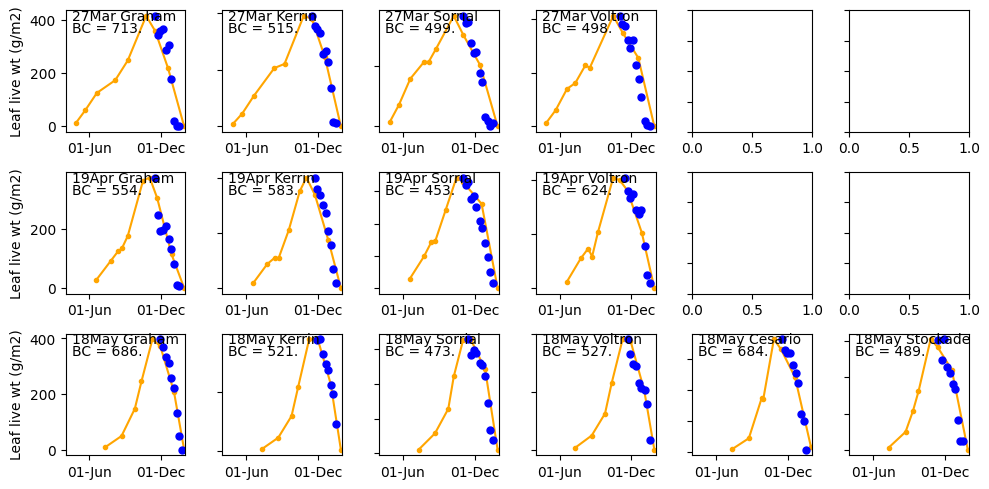

In [20]:
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['27Mar','19Apr','18May'] :
    for c in ['Graham','Kerrin','Sorrial','Voltron','Cesario','Stockade']:
        try:
            ax = Graph.add_subplot(3,6,pos)
            cf = QuadratData23.loc[(s,c),'Wheat.Leaf.Live.Wt'].max()/RandomStems23.loc[(s,c),'Wheat.Leaf.Live.Wt/stem (g)'].max()
            RandomStems23.loc[(s,c),'Corrected_Wheat.Leaf.Live.Wt'] = RandomStems23.loc[(s,c),'Wheat.Leaf.Live.Wt/stem (g)']*cf
            plt.plot(QuadratData23.loc[(s,c),'Clock.Today'],
                     QuadratData23.loc[(s,c),'Wheat.Leaf.Live.Wt'],'o-',ms=3,color = 'orange')

            plt.plot(RandomStems23.loc[(s,c),'Clock.Today'],
                     RandomStems23.loc[(s,c),'Corrected_Wheat.Leaf.Live.Wt'],'o',ms=5,color = 'b')
            #plt.ylim(0,500)
            plt.xlim(dt.date(2023,4,1),dt.date(2024,2,1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            plt.text(0.05,0.95,s+' '+c,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            if c == 'Graham':
                plt.ylabel('Leaf live wt (g/m2)')
            else:
                plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
            pos +=1
        except:
            pos+=1
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
plt.tight_layout()

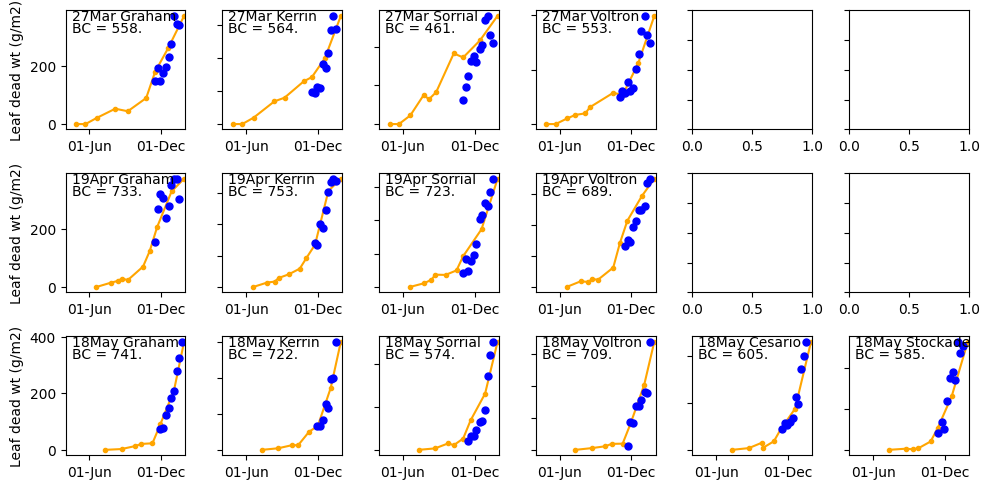

In [21]:
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['27Mar','19Apr','18May'] :
    for c in ['Graham','Kerrin','Sorrial','Voltron','Cesario','Stockade']:
        try:
            ax = Graph.add_subplot(3,6,pos)
            cf = QuadratData23.loc[(s,c),'Wheat.Leaf.Dead.Wt'].max()/RandomStems23.loc[(s,c),'Wheat.Leaf.Dead.Wt/stem (g)'].max()
            RandomStems23.loc[(s,c),'Corrected_Wheat.Leaf.Dead.Wt'] = RandomStems23.loc[(s,c),'Wheat.Leaf.Dead.Wt/stem (g)']*cf
            plt.plot(QuadratData23.loc[(s,c),'Clock.Today'],
                     QuadratData23.loc[(s,c),'Wheat.Leaf.Dead.Wt'],'o-',ms=3,color = 'orange')

            plt.plot(RandomStems23.loc[(s,c),'Clock.Today'],
                     RandomStems23.loc[(s,c),'Corrected_Wheat.Leaf.Dead.Wt'],'o',ms=5,color = 'b')
            #plt.ylim(0,500)
            plt.xlim(dt.date(2023,4,1),dt.date(2024,2,1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            plt.text(0.05,0.95,s+' '+c,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            if c == 'Graham':
                plt.ylabel('Leaf dead wt (g/m2)')
            else:
                plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
            pos +=1
        except:
            pos+=1
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
plt.tight_layout()

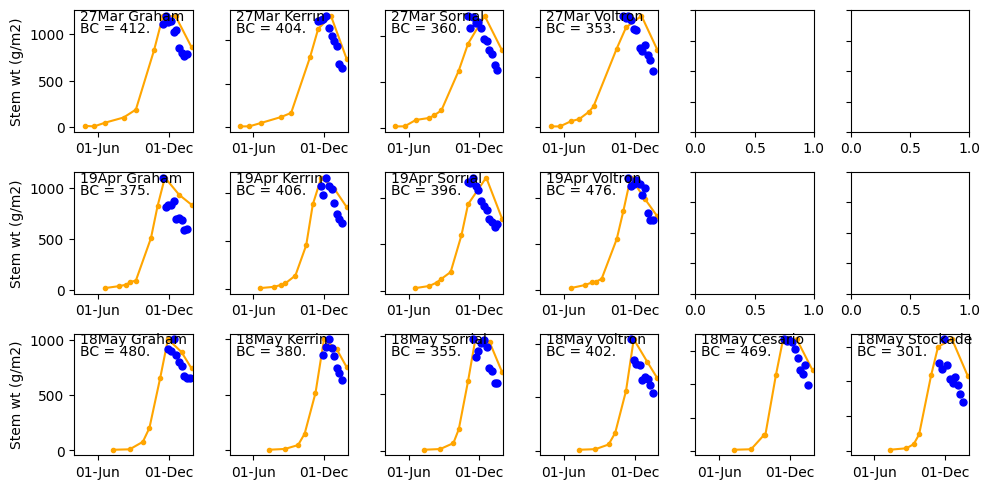

In [22]:
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['27Mar','19Apr','18May'] :
    for c in ['Graham','Kerrin','Sorrial','Voltron','Cesario','Stockade']:
        try:
            ax = Graph.add_subplot(3,6,pos)
            cf = QuadratData23.loc[(s,c),'Wheat.Stem.Wt'].max()/RandomStems23.loc[(s,c),'Wheat.Stem.Wt/stem (g)'].max()
            RandomStems23.loc[(s,c),'Corrected_Wheat.Stem.Wt'] = RandomStems23.loc[(s,c),'Wheat.Stem.Wt/stem (g)']*cf
            plt.plot(QuadratData23.loc[(s,c),'Clock.Today'],
                     QuadratData23.loc[(s,c),'Wheat.Stem.Wt'],'o-',ms=3,color = 'orange')

            plt.plot(RandomStems23.loc[(s,c),'Clock.Today'],
                     RandomStems23.loc[(s,c),'Corrected_Wheat.Stem.Wt'],'o',ms=5,color = 'b')
            #plt.ylim(0,500)
            plt.xlim(dt.date(2023,4,1),dt.date(2024,2,1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            plt.text(0.05,0.95,s+' '+c,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            if c == 'Graham':
                plt.ylabel('Stem wt (g/m2)')
            else:
                plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
            pos +=1
        except:
            pos+=1
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
plt.tight_layout()

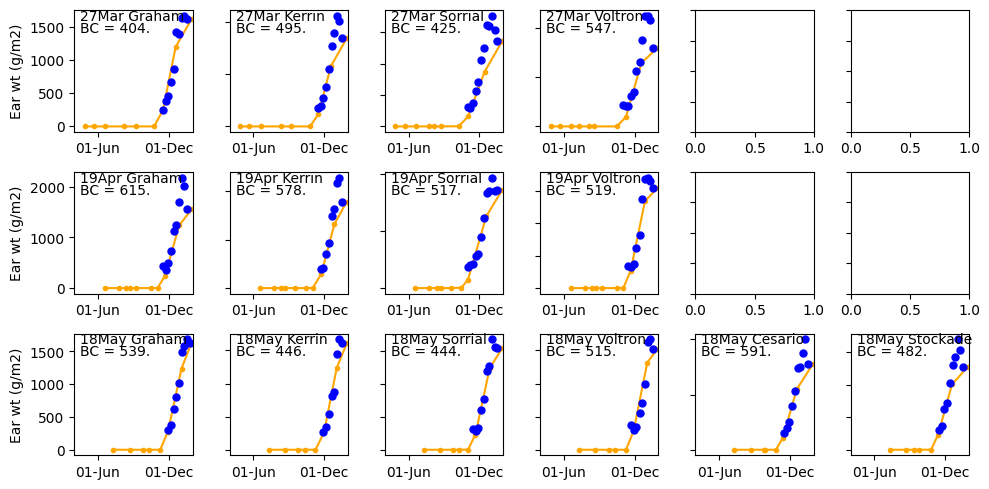

In [23]:
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['27Mar','19Apr','18May'] :
    for c in ['Graham','Kerrin','Sorrial','Voltron','Cesario','Stockade']:
        try:
            ax = Graph.add_subplot(3,6,pos)
            cf = QuadratData23.loc[(s,c),'Wheat.Ear.Wt'].dropna().iloc[-1]/RandomStems23.loc[(s,c),'Wheat.Ear.Wt/stem (g)'].dropna().iloc[-1]
            RandomStems23.loc[(s,c),'Corrected_Wheat.Ear.Wt'] = RandomStems23.loc[(s,c),'Wheat.Ear.Wt/stem (g)']*cf
            plt.plot(QuadratData23.loc[(s,c),'Clock.Today'],
                     QuadratData23.loc[(s,c),'Wheat.Ear.Wt'],'o-',ms=3,color = 'orange')

            plt.plot(RandomStems23.loc[(s,c),'Clock.Today'],
                     RandomStems23.loc[(s,c),'Corrected_Wheat.Ear.Wt'],'o',ms=5,color = 'b')
            #plt.ylim(0,500)
            plt.xlim(dt.date(2023,4,1),dt.date(2024,2,1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            plt.text(0.05,0.95,s+' '+c,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            plt.text(0.05,0.85,'BC = '+str(cf)[:4],horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            if c == 'Graham':
                plt.ylabel('Ear wt (g/m2)')
            else:
                plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
            pos +=1
        except:
            pos+=1
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
plt.tight_layout()

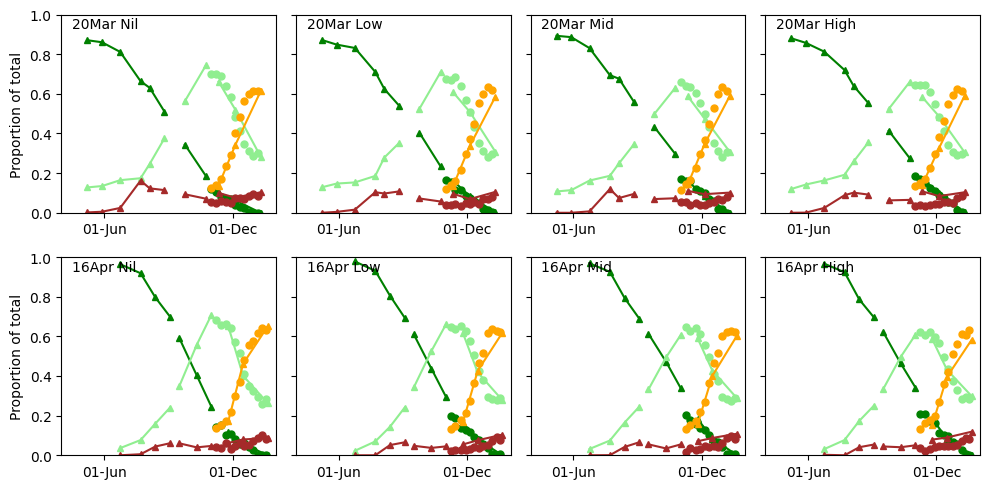

In [24]:
colours = dict(zip(biomassVars,['green','lightgreen', 'brown','orange']))
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['20Mar','16Apr']:
    for n in ['Nil','Low','Mid','High']:
        ax = Graph.add_subplot(2,4,pos)
        for v in biomassVars:
            plt.plot(RandomStems.loc[(s,n),'Clock.Today'],
                 RandomStems.loc[(s,n),'Propn_'+v],'o',ms=5,color = colours[v])
            plt.plot(QuadratData.loc[(s,n),'Clock.Today'],
                     QuadratData.loc[(s,n),'Propn_'+v],'^-',ms=5,color = colours[v])
        plt.ylim(0,1)
        plt.xlim(dt.date(2024,4,1),dt.date(2025,2,1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        plt.text(0.05,0.95,s+' '+n,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        if n == 'Nil':
            plt.ylabel('Proportion of total')
        else:
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
        pos +=1
plt.tight_layout()

In [25]:
# Delete proportion data on first harvest date as partitioning methodology was suspect and data do not make sense
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-04-28','Propn_Wheat.Leaf.Live.Wt'] = np.nan
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-04-28','Propn_Wheat.Stem.Wt'] = np.nan
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-06-19','Propn_Wheat.Leaf.Live.Wt'] = np.nan
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-06-19','Propn_Wheat.Stem.Wt'] = np.nan
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-07-11','Propn_Wheat.Leaf.Live.Wt'] = np.nan
QuadratData23.loc[QuadratData23.loc[:,'Clock.Today'] == '2023-07-11','Propn_Wheat.Stem.Wt'] = np.nan

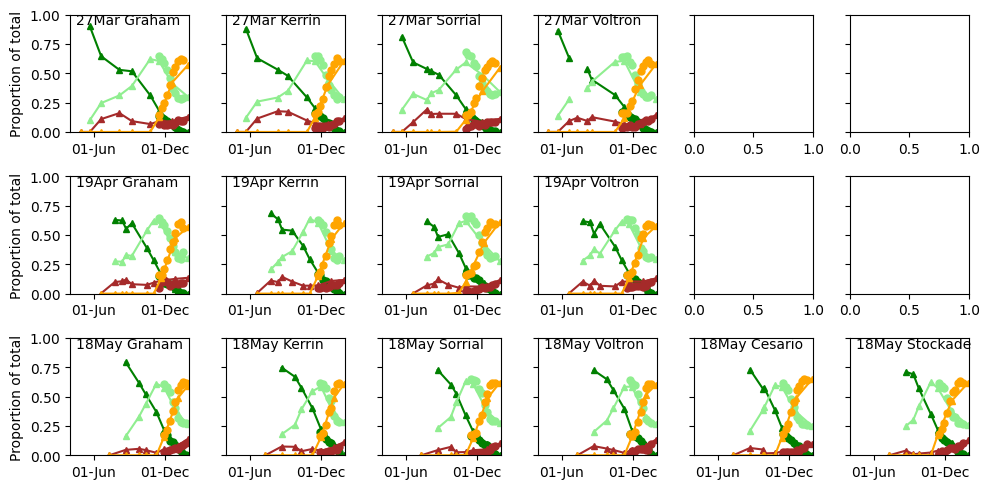

In [26]:
colours = dict(zip(biomassVars,['green','lightgreen', 'brown','orange']))
Graph =  plt.figure(figsize=(10,5))
pos = 1
for s in ['27Mar','19Apr','18May'] :
    for c in ['Graham','Kerrin','Sorrial','Voltron','Cesario','Stockade']:
        try:
            ax = Graph.add_subplot(3,6,pos)
            for v in biomassVars:
                plt.plot(RandomStems23.loc[(s,c),'Clock.Today'],
                     RandomStems23.loc[(s,c),'Propn_'+v],'o',ms=5,color = colours[v])
                plt.plot(QuadratData23.loc[(s,c),'Clock.Today'],
                         QuadratData23.loc[(s,c),'Propn_'+v],'^-',ms=5,color = colours[v])
            plt.ylim(0,1)
            plt.xlim(dt.date(2023,4,1),dt.date(2024,2,1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            plt.text(0.05,0.95,s+' '+c,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
            if c == 'Graham':
                plt.ylabel('Proportion of total')
            else:
                plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
            pos +=1
        except:
            pos+=1
            plt.tick_params(axis='y',which='major',left=True,right=False,labelleft=False)
plt.tight_layout()

In [27]:
biomassVars

['Wheat.Leaf.Live.Wt', 'Wheat.Stem.Wt', 'Wheat.Leaf.Dead.Wt', 'Wheat.Ear.Wt']

In [28]:
RS23PrpnData = RandomStems23.loc[:,['SimulationName','Clock.Today','Propn_Wheat.Leaf.Live.Wt', 'Propn_Wheat.Stem.Wt', 'Propn_Wheat.Leaf.Dead.Wt', 'Propn_Wheat.Ear.Wt']]
RS23PrpnData.set_index(['SimulationName','Clock.Today'],inplace=True)

In [29]:
RS24PrpnData = RandomStems.loc[:,['SimulationName','Clock.Today','Propn_Wheat.Leaf.Live.Wt', 'Propn_Wheat.Stem.Wt', 'Propn_Wheat.Leaf.Dead.Wt', 'Propn_Wheat.Ear.Wt']]
RS24PrpnData.set_index(['SimulationName','Clock.Today'],inplace=True)

In [30]:
QD23PrpnData = QuadratData23.loc[:,['SimulationName','Clock.Today','Propn_Wheat.Leaf.Live.Wt', 'Propn_Wheat.Stem.Wt', 'Propn_Wheat.Leaf.Dead.Wt', 'Propn_Wheat.Ear.Wt']]
QD23PrpnData.set_index(['SimulationName','Clock.Today'],inplace=True)

In [31]:
QD24PrpnData = QuadratData.loc[:,['SimulationName','Clock.Today','Propn_Wheat.Leaf.Live.Wt', 'Propn_Wheat.Stem.Wt', 'Propn_Wheat.Leaf.Dead.Wt', 'Propn_Wheat.Ear.Wt']]
QD24PrpnData.set_index(['SimulationName','Clock.Today'],inplace=True)

In [32]:
PrpnData = pd.concat([RS23PrpnData,RS24PrpnData,QD23PrpnData,QD24PrpnData])
PrpnData.columns = ['Wheat.Leaf.LiveWtProportion','Wheat.Stem.WtProportion','Wheat.Leaf.DeadWtProportion','Wheat.Ear.WtProportion']
PrpnData.dropna(how='all',inplace=True)
PrpnData.sort_index(inplace=True)

In [33]:
PrpnData.to_clipboard()